<font color='darkblue'>
    
</font>

In [1]:
# Imports
import networkx as nx
import pandas as pd
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
import urllib.request
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import io
from wordcloud import WordCloud
from collections import defaultdict
import math
from fa2 import ForceAtlas2

In [386]:
from community import community_louvain
import matplotlib.cm as cm
from collections import Counter
from nltk.stem import WordNetLemmatizer 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import collections

# Assignment 2

## Part 0: Building the network

To create our network, we downloaded the Zelda Wiki pages for all characters in BotW (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions!
 
- Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.
 
To gather all the hyperlinks we collected the wiki pages for each ally,enemy and boss and saved them as "txt" files. Then we went through all the ".txt" files and used regex to extract the links in each file.
 
We then checked for each links if they were linking to a character, comparing it the list of characters collected earlier.If the links was to another character the connection was saved in a dataframe and used to build the network later.

- Show the regular expression(s) you have built and explain in details how it works.
 
The regex patterns we used to extract the links were the following:
 
    \[\[(.*?)(?:\|.*?)?\]\]                         (1)
    \{\{(?:Term|Plural)\|BotW\|(.*?)(?:\|link)?\}\} (2)
 
Pattern (1) is used to extract links in the format "[[ Name ]]", where name is the name of the refrenced character. The pattern looks for the square brackects [ [ ] ], but we have to use the escape character '\' to so we are specifically looking for the square brackets, as they have special meaning in regex.
 
Inside the square brackets, the pattern is looking for two groups, indicated by the round brackets. The leftmost is the name we are extracting, it specifies to look for any character, that can occur any number of times. Inside the rightmost round brackets is another group that can, or can not apper. This is done because some links are in the format [ [ Name | something]]. As we don't want to extract the "| something", this is seperated from the name and discarded. The "?:" in the beginning of the group.
 
Pattern (2) is used to extract links in the form "{{Term|Botw|Name|Link}}" or "{{Plural|Botw|Name|Link}} where we want to extract the "Name" as before. The pattern looks for curly brackects beginning with either "Term|Botw|" or "Plural|Botw". This text is grouped and discarded. Next the pattern matched the following group, which is the name. The it looks for any number of any characters. Next the  pattern matches a group in the format "|link" and discards it. There were some cases where this last group was not present, which is why there is a question mark at the end of the group.


## Part 1: Network visualization and basic stats

In [2]:
#Building the network from the .txt files
failed = ['Granté','Metal Boulder','Spiked Boulder','Central Hy'] #Characters that I failed to retrive info on
charactersDf = pd.read_csv('charecters.csv')


In [3]:
def nodeInfo(text):
    genderRe1 = re.findall(r'(?:gender=\s)([a-zA-Z]*)(?:<.*?\/>)?(?:\{\{.*?\}\})?',text)
    if genderRe1:
        if genderRe1[0] == '':
            gender = 'Unknown'
        else:
            gender = genderRe1[0]
    else:
        gender = 'Unknown'
    raceRe1 = re.findall(r'(?:race=\s)\{\{Term\|BotW\|(.*?)\|link\}\}',text)
    raceRe2 = re.findall(r'(?:race=\s)\[\[(.*?)(?:\|.*?)?\]\]',text)

    if raceRe1:
        race = raceRe1[0]
    elif raceRe2:
        race = raceRe2[0] 
    else:
        race = 'none'
    pattern1 = '\[\[(.*?)(?:\|.*?)?\]\]'
    pattern2 = '\{\{Term\|BotW\|(.*?)\|link\}\}'
    square = re.findall(pattern1,text)
    curly = re.findall(pattern2,text)
    edges = square + curly
    return gender,race,edges

In [4]:
def filterC(chars,charList):
    ret = []
    i = 0
    for i in range(len(chars)):
        if chars[i] in charList:
            ret.append(chars[i])
    return ret

In [5]:
def tuples(name, list):
    tmp = []
    for item in list:
        tmp.append((name,item))
    return tmp

In [6]:
nameList = list(charactersDf.Name)
networkInfoDf = pd.DataFrame(columns={"name","race","gender","charlist",'role'})
for row in charactersDf.iterrows():
    try:
        name= row[1]['Name']
        with open("utf8txtfiles/" + name + '.txt',encoding='utf-8') as f:
            text = f.read()
        g,r,e = nodeInfo(text)
        charList = filterC(e,nameList)
        networkInfoDf = networkInfoDf.append({"name":name,"race":r,"gender":g,"charlist":tuples(name,charList),"role":row[1]['type']},ignore_index=True)
    except:
        print(name)
    
    


Granté
Magma Bomb
Metal Boulder


In [7]:
G = nx.DiGraph()
nameList = list(charactersDf.Name)
#Add all nodes to graph
for row in networkInfoDf.iterrows():
    name = row[1]['name']
    gender = row[1]['gender']
    race = row[1]['race']
    role = row[1]['role']
    G.add_node(name,race = race, gender = gender,role=role)

for row in networkInfoDf.iterrows():
    charList = row[1]['charlist']
    G.add_edges_from(charList)

- What is the number of nodes in the network?
- More importantly, what is the number of links?

In [8]:
GunD = G.to_undirected()
giant = list(max(nx.connected_components(GunD), key=len))
gcc = G.subgraph(giant).copy()
print('Number of nodes and links in the network')
print('------------------------------------------')
print(nx.info(gcc))

Number of nodes and links in the network
------------------------------------------
Name: 
Type: DiGraph
Number of nodes: 528
Number of edges: 1478
Average in degree:   2.7992
Average out degree:   2.7992


- Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [9]:
AllyInDegree = []
AllyOutDegree = []
AllyTotalDegree = []

EnemyInDegree = []
EnemyOutDegree = []
EnemyTotalDegree = []
for node in gcc.nodes(data=True):
    if bool(node[1]):
        if node[1]['role'] == 'Ally':
            AllyInDegree.append((node[0],gcc.in_degree(node[0])))
            AllyOutDegree.append((node[0],gcc.out_degree(node[0])))
            AllyTotalDegree.append((node[0],gcc.degree(node[0])))
        else:
            EnemyInDegree.append((node[0],gcc.in_degree(node[0])))
            EnemyOutDegree.append((node[0],gcc.out_degree(node[0])))
            EnemyTotalDegree.append((node[0],gcc.degree(node[0])))

inDegree = [(node,G.in_degree(node)) for node in G.nodes()]
outDegree = [(node,G.out_degree(node)) for node in G.nodes()]
totalDegree = [(node,G.degree(node)) for node in G.nodes()]
print( 'The charecter with the highest \'in\' degree is: ',max(inDegree,key=lambda item:item[1])[0])
print( 'The charecter with the highest \'out\' degree is: ',max(outDegree,key=lambda item:item[1])[0])
print( 'The charecter with the highest \'total\' degree is: ',max(totalDegree,key=lambda item:item[1])[0])

The charecter with the highest 'in' degree is:  Link
The charecter with the highest 'out' degree is:  Traysi
The charecter with the highest 'total' degree is:  Link


As expected, the main character of the series, Link, is the most connected character in terms of 'in' degree and in the undirected graph. As the others of this report are not totally familiar with the Zelda games, we are not familiar with the character Traysi, so we can't really comment on that.

- Who are the top 5 most connected allies (again in terms of in/out-degree)?


In [10]:
AllyInDegree.sort(key=lambda y: y[1],reverse=True)
AllyOutDegree.sort(key=lambda y: y[1],reverse=True)
AllyTotalDegree.sort(key=lambda y: y[1],reverse=True)

EnemyInDegree.sort(key=lambda y: y[1],reverse=True)
EnemyOutDegree.sort(key=lambda y: y[1],reverse=True)
EnemyTotalDegree.sort(key=lambda y: y[1],reverse=True)
print("The allies with the highest in degree are:")
for i in range (5):
    print(AllyInDegree[i])
print('----------------------------')
print("The allies with the highest out degree are:")
for i in range (5):
    print(AllyOutDegree[i])
print('----------------------------')
print("The top 5 most connected allies are:")
for i in range (5):
    print(AllyTotalDegree[i])

The allies with the highest in degree are:
('Link', 377)
('Riju', 22)
('Princess Zelda', 19)
('Mipha', 18)
('Sidon', 13)
----------------------------
The allies with the highest out degree are:
('Traysi', 14)
('Urbosa', 11)
('Link', 10)
('Daruk', 9)
('Impa', 9)
----------------------------
The top 5 most connected allies are:
('Link', 387)
('Princess Zelda', 27)
('Riju', 27)
('Mipha', 25)
('Impa', 21)


- Who are the top 5 most connected enemies -- bosses included -- (again in terms of in/out-degree)?


In [11]:
print("The enemies with the highest in degree are:")
for i in range (5):
    print(EnemyInDegree[i])
print('----------------------------')
print("The enemies with the highest out degree are:")
for i in range (5):
    print(EnemyOutDegree[i])
print('----------------------------')
print("The top 5 most connected enemies are:")
for i in range (5):
    print(EnemyTotalDegree[i])

The enemies with the highest in degree are:
('Calamity Ganon', 86)
('Gerudo Desert', 55)
('Bokoblin', 11)
('Malice', 9)
('Moblin', 8)
----------------------------
The enemies with the highest out degree are:
('Stalizalfos', 11)
('Moblin', 10)
('Silver Lizalfos', 9)
('Gerudo Desert', 9)
('Blue Lizalfos', 8)
----------------------------
The top 5 most connected enemies are:
('Calamity Ganon', 91)
('Gerudo Desert', 64)
('Moblin', 18)
('Stalizalfos', 18)
('Silver Lizalfos', 13)


- Plot the in- and out-degree distributions. 
- - What do you observe? 
- - Can you explain why the in-degree distribution is different from the out-degree distribution?

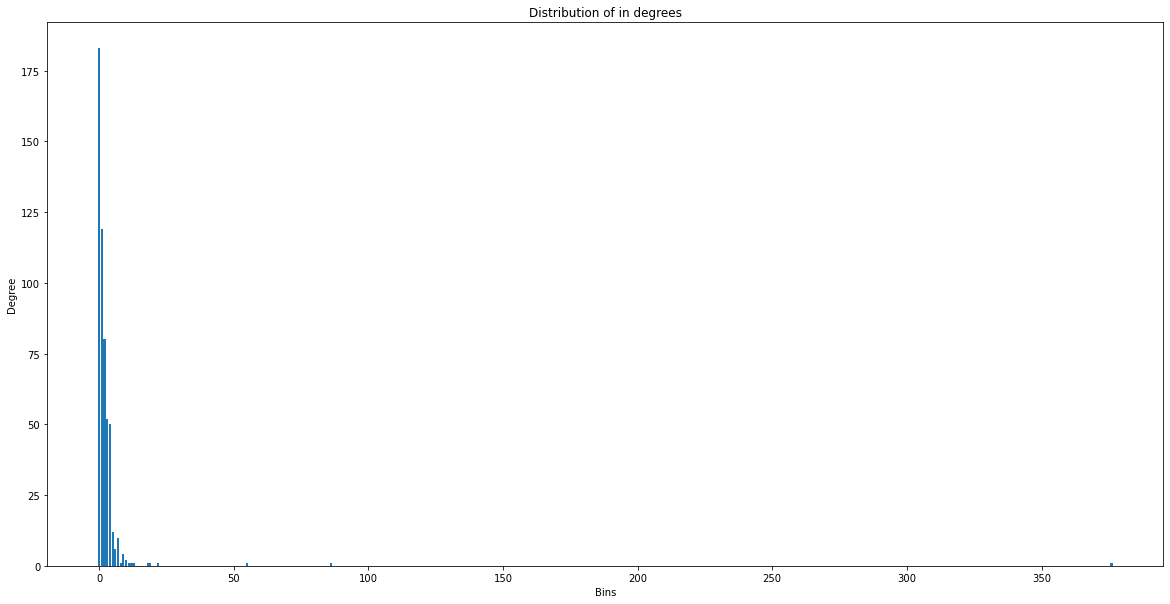

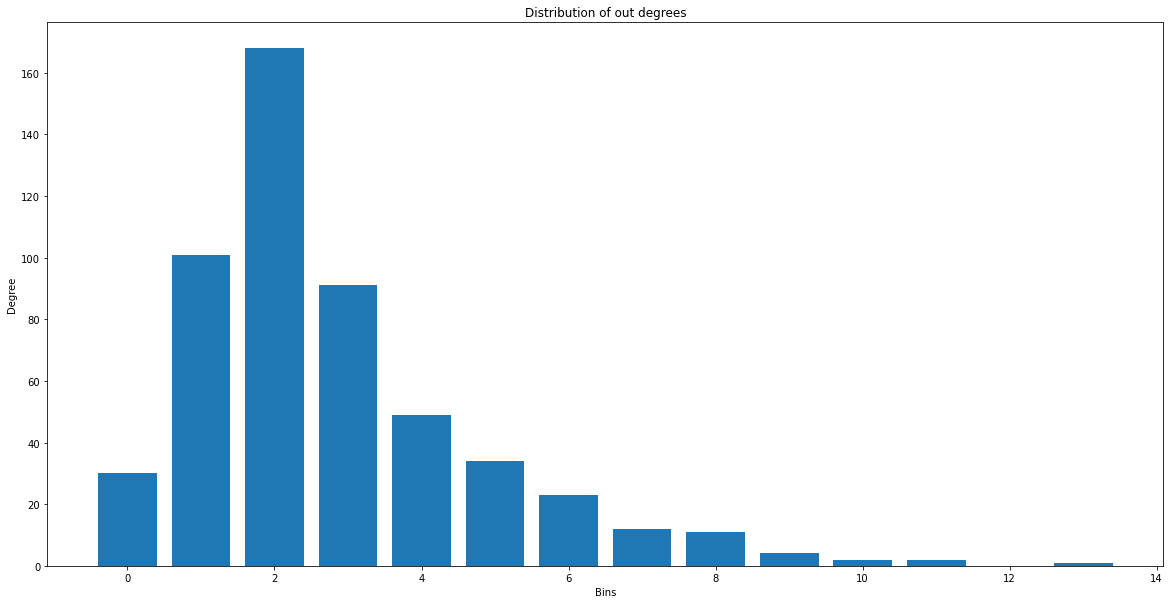

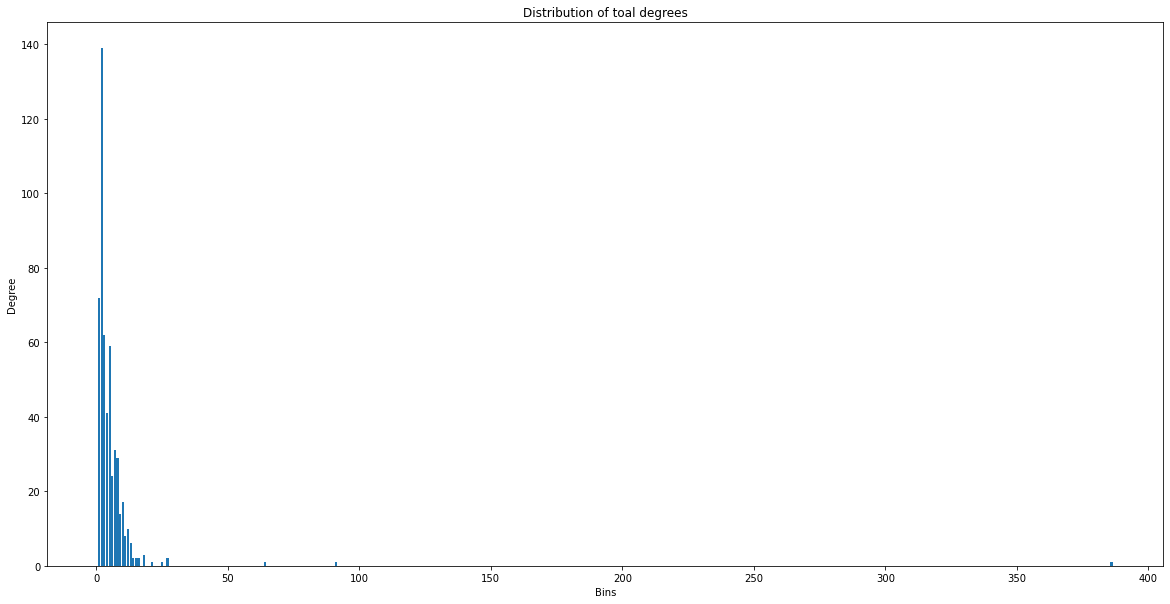

In [12]:
inDegree = [gcc.in_degree(node) for node in gcc.nodes()]
outDegree = [gcc.out_degree(node) for node in gcc.nodes()]
totalDegree = [gcc.degree(node) for node in gcc.nodes()]

maxIn = max(inDegree,key=lambda item:item)
maxOut = max(outDegree,key=lambda item:item)
maxTotal = max(totalDegree,key=lambda item:item)

minIn = min(inDegree,key=lambda item:item)
minOut = min(outDegree,key=lambda item:item)
minTotal = min(totalDegree,key=lambda item:item)

vIn = np.linspace(minIn, maxIn, maxIn-minIn+1)
counts, vIn = np.histogram(inDegree, vIn)
plt.figure(figsize=(20,10))
plt.bar(vIn[:-1], counts)
plt.xlabel("Bins")
plt.ylabel("Degree")
plt.title('Distribution of in degrees')

vOut = np.linspace(minOut, maxOut, maxOut-minOut+1)
counts, vOut = np.histogram(outDegree, vOut)
plt.figure(figsize=(20,10))
plt.bar(vOut[:-1], counts)
plt.xlabel("Bins")
plt.ylabel("Degree")
plt.title('Distribution of out degrees')

vTotal = np.linspace(minTotal, maxTotal, maxTotal-minTotal+1)
counts, vTotal = np.histogram(totalDegree, vTotal)
plt.figure(figsize=(20,10))
plt.bar(vTotal[:-1], counts)
plt.xlabel("Bins")
plt.ylabel("Degree")
plt.title('Distribution of toal degrees')


plt.show()

What we can see from these degree distributions is that the out-degree is much more evenly disrtibuted than the in degree. This would suggest that every character's page has a similar amount of hyperlinks. The in-degree distribution is not even at all. The vast majority of nodes have a few in-edges as can be seen in the distribution. There are a few nodes (characters) with a very high degree of in-edges. We suspect that these are the main characters in the game (e.g. Link), so a large number of minor characters refrence them in their wiki-page.

- Find the exponent of the degree distribution (by using the powerlaw package) for the in- and out-degree distribution. What does it say about our network?

In [244]:
#TODO

- Compare the degree distribution of the undirected graph to a random network with the same number of nodes and probability of connection p. Comment your results.

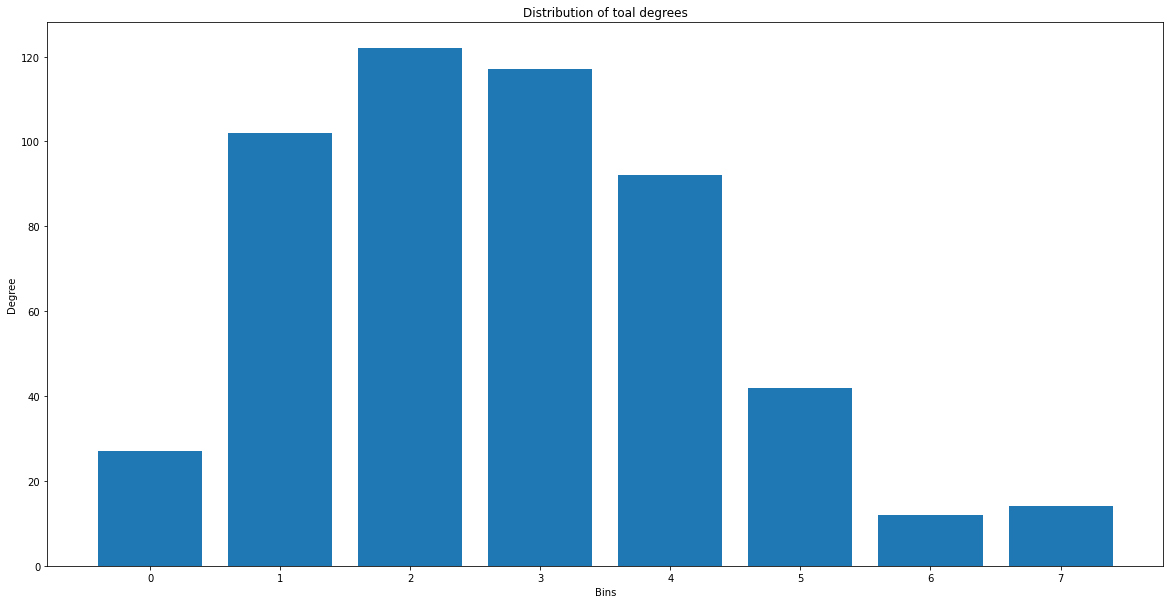

In [13]:
n = gcc.number_of_nodes()
k = gcc.number_of_edges()/ gcc.number_of_nodes()
p = k/(n-1)
gnp = nx.fast_gnp_random_graph(n,p)

degreeGnp = [gnp.degree(node) for node in gnp.nodes()]
maxGnp = max(degreeGnp,key=lambda item:item)
minGnp = min(degreeGnp,key=lambda item:item)

vGnp = np.linspace(minGnp, maxGnp, maxGnp-minGnp+1)
countsGnp, vGnp = np.histogram(degreeGnp, vGnp)
plt.figure(figsize=(20,10))
plt.bar(vGnp[:-1], countsGnp)
plt.xlabel("Bins")
plt.ylabel("Degree")
plt.title('Distribution of toal degrees')
plt.show()

Since the random network (Gnp) is undirected, we can only compare it's degree distribution to the total degree distribution of our Zelda network. We can see that the average degree in the random network is much more evenly distributed than the Zelda network. Since the network is created at random, it is very unlikely that it would have a distribution similar to the Zelda network, where the majority of nodes have only one edge and a single node has around 400 edges, as we see in the Zelda network. The distribution of the random networks resembles a normal distribution.

### Exercise 1b: Visualization

Create a nice visualization of the total (undirected) network:

Color nodes according to the role;

Scale node-size according to degree;

Get node positions based on the Force Atlas 2 algorithm;

Whatever else you feel like that would make the visualization nicer.


In [14]:
d = dict(gcc.degree)

# nx.draw(gcc, nodelist=d.keys(), node_size=[(v+1) * 20 for v in d.values()])
# plt.figure(figsize=(20,10))
# plt.show()
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.5,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=100.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(gcc,  iterations=2000)

100%|██████████| 2000/2000 [00:14<00:00, 139.99it/s]

BarnesHut Approximation  took  2.16  seconds
Repulsion forces  took  11.36  seconds
Gravitational forces  took  0.08  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.33  seconds


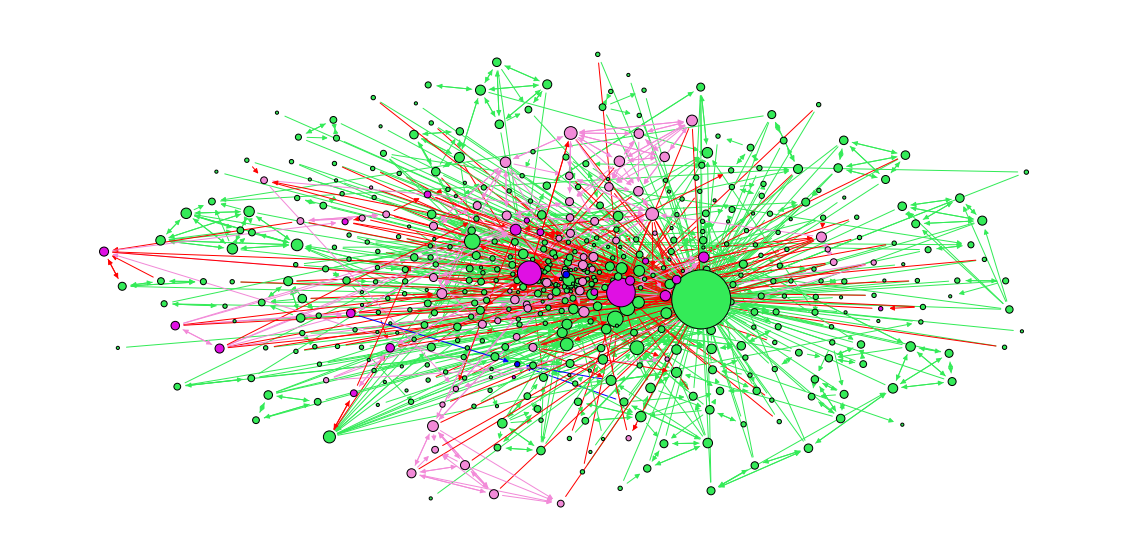

In [15]:
list_degree=list(gcc.degree()) #this will return a list of tuples each tuple is(node,deg)
nodes , degree = map(list, zip(*list_degree)) #build a node list and corresponding degree list

#Set node color
color_map = []
for node in gcc.nodes(data=True):
    if 'role' in node[1].keys():
        if node[1]['role'] == 'Ally':
            color_map.append('#34eb58')#Green
        if node[1]['role'] == 'Enemy':
            color_map.append('#f28ad8')#Pink
        if node[1]['role'] == 'Boss':
            color_map.append('#df10e3')#Purpe
    else:
        color_map.append('#0000ff')
edgeColor_map =[]
#Set edge color
for edge in gcc.edges():
    source = gcc.nodes[edge[0]]
    target = gcc.nodes[edge[1]]
    if 'role' in source.keys() and 'role' in target.keys() :
        if source['role'] == target['role']:
            if source['role'] == 'Ally' and target['role'] == 'Ally':
                edgeColor_map.append("#34eb58")#Green
            if source['role'] == 'Enemy' and target['role'] == 'Enemy':
                edgeColor_map.append("#f28ad8")#Pink
            if source['role'] == 'Boss' and target['role'] == 'Enemy':
                edgeColor_map.append("#f28ad8")#Pink
            if source['role'] == 'Enemy' and target['role'] == 'Boss':
                edgeColor_map.append("#f28ad8")#Pink
            if source['role'] == 'Boss' and target['role'] == 'Boss':
                edgeColor_map.append("#f28ad8")#Pink
        else:
            edgeColor_map.append('#ff0000')#Red
    else:
        edgeColor_map.append('#0000ff')
        


plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(gcc, positions, nodelist=nodes, node_size=[(v * 9)+1 for v in degree], node_color=color_map,edgecolors="black")
nx.draw_networkx_edges(gcc, positions, edge_color=edgeColor_map)
plt.axis('off')

plt.show()

# list_degree=list(gcc.degree()) #this will return a list of tuples each tuple is(node,deg)
# nodes , degree = map(list, zip(*list_degree)) #build a node list and corresponding degree list
# plt.figure(figsize=(20,10))
# nx.draw(gcc, nodelist=nodes, node_size=[(v * 5)+1 for v in degree])
# plt.show() #ploting the graph 

Green nodes are allies, and green edges are connections between allies.

Pink nodes are enemies and purple nodes are bosses. Pink edges are between all 'non-ally' characters.

Red edges are between characters with different roles (Ally -> Boss/enemy or the other way around)

* <font color='darkblue'>
    Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?
</font>

## Part 2: Word-clouds

* <font color='darkblue'>
    Create a word-cloud for each race of the five champions of Hyrule (i.e. Hylian, Zora, Goron, Gerudo, and Rito) according to either TC-IDF. Feel free to make it as fancy as you like. Explain your process and comment on your results.
</font>

In [387]:
#Create the corpus
corpus_root = 'cleanFiles'
newcorpus = PlaintextCorpusReader(corpus_root, '.*')

In [388]:
df_characters = pd.read_csv('Zelda.csv')

In [389]:
for index, row in df_characters.iterrows():
    row['Name'] = row['Name'].replace(" ", "_")
names = df_characters.Name.values.tolist()

In [390]:
#CLEANING THE TEXT FILES

stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
wnl = nltk.WordNetLemmatizer()
listOfCleanCheckNames = []

more_stopwords = {'character', 'zelda', 'wild', '=', 'ha'}
stop_words = stop_words.union(more_stopwords)

for name in names:
    file1 = open("txt files/" + name + ".txt")
    theText = file1.read()

    # Regex
    theText = re.sub('==.*?==', '', theText)

    # Remove every name from every text file
    for test in names:
        theText = re.sub(test, '', theText)

    # Removing punctuations
    words = tokenizer.tokenize(theText)

    for r in words:
        #Setting to lowercase
        r = r.lower()
        
        # Lemmatization
        r = wnl.lemmatize(r)
        
        if not r in stop_words:
            appendFile = open("cleanFiles/" + name + ".txt",'a')
            appendFile.write(" "+r)
            appendFile.close()

        
    listOfCleanCheckNames.append(name)

In [391]:
# Create dataframes for each Race
df_Hylian = df_characters.loc[(df_characters['Race'] == 'Hylian')]
df_Zora = df_characters.loc[(df_characters['Race'] == 'Zora')]
df_Goron = df_characters.loc[(df_characters['Race'] == 'Goron')]
df_Gerudo = df_characters.loc[(df_characters['Race'] == 'Gerudo')]
df_Rito = df_characters.loc[(df_characters['Race'] == 'Rito')]

In [392]:
# Extract the names from the dataframes for future use
hylians = df_Hylian.Name.values
zoras = df_Zora.Name.values
gorons = df_Goron.Name.values
gerudos = df_Gerudo.Name.values
ritos = df_Rito.Name.values

In [393]:
# Calculate TC-IDF ranking
def calcRate(namesInRace):
    wordsInRace = defaultdict(list)
    appearsInCorpus = defaultdict(list)
    
    for name in namesInRace:
        theText = nltk.Text(newcorpus.words(name + '.txt'))
        fdist = FreqDist(theText)
        
        for word in fdist:
            wordTC = fdist[word]
                
            wordsInRace[word].append(wordTC)
            appearsInCorpus[word].append(name)
    
    superstring = ""
    for key, value in wordsInRace.items():
        TC = sum(value)
        IDF = math.log(len(namesInRace) / len(appearsInCorpus[key]))

        TCIDF = math.ceil(TC*IDF)
        
        superstring += (key + " ") * TCIDF

    return superstring

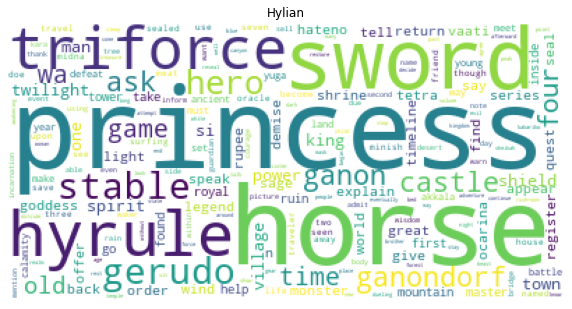

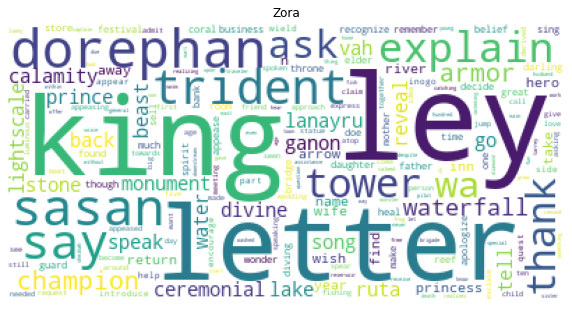

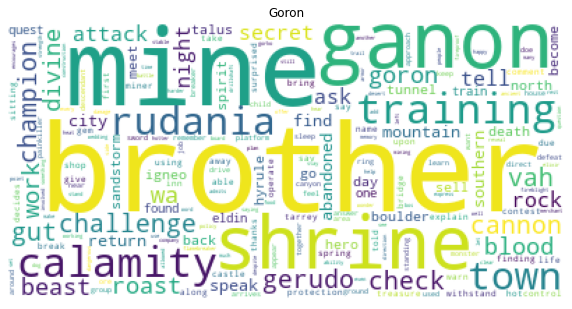

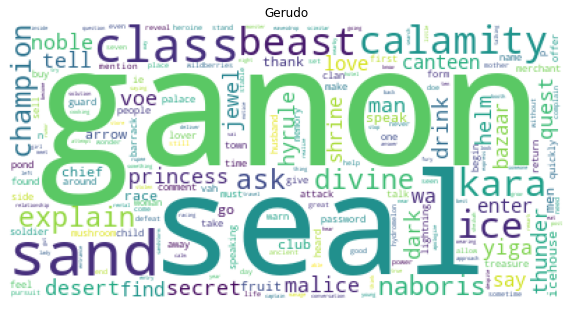

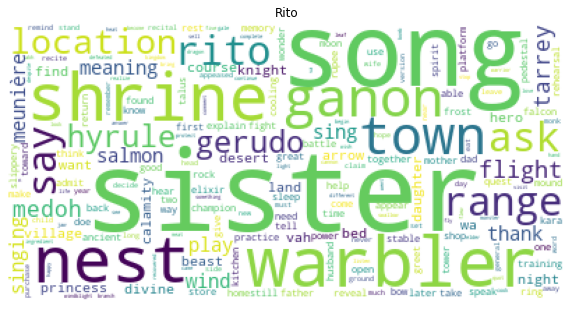

In [394]:
hyliansCloud = calcRate(hylians)
zorasCloud = calcRate(zoras)
goronsCloud = calcRate(gorons)
gerudosCloud = calcRate(gerudos)
ritosCloud = calcRate(ritos)

plt.figure( figsize=(10,6))
wordcloud = WordCloud(background_color="white", collocations = False).generate(hyliansCloud)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Hylian")
plt.show()

plt.figure( figsize=(10,6))
wordcloud = WordCloud(background_color="white", collocations = False).generate(zorasCloud)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.title("Zora")
plt.show()

plt.figure( figsize=(10,6))
wordcloud = WordCloud(background_color="white", collocations = False).generate(goronsCloud)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.title("Goron")
plt.show()

plt.figure( figsize=(10,6))
wordcloud = WordCloud(background_color="white", collocations = False).generate(gerudosCloud)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.title("Gerudo")
plt.show()

plt.figure( figsize=(10,6))
wordcloud = WordCloud(background_color="white", collocations = False).generate(ritosCloud)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.title("Rito")
plt.show()

* Explain your process and comment on your results.

We create a word-cloud for each of the five champions' race. Firstly a Pandas DataFrame is created, it is then used to make an array of all the names.
We create another 5 DataFrames containing only information on characters in a specific race. Five smaller name-arrays are made, one for each DataFrame. 
The original name array is used to loop over all the text files in a subfolder. At this point all the text files are cleaned. 
- remove everything between ==
- remove every character names from the text files.
- tokenize the text and remove punctuations
- make every word lowercase
- remove stop words (such as what, no, but, to, an, be, by ...)
- lemmatize words. Make sure the words are in the right manners, as in the dictionary.
The newly cleaned string is then written to a text file - for every name in the name-array.

Next the TC-IDF is calculated.
And lastly a word cloud is created for each race. 5 in total.

## Part 3: Communities and TF-IDF

* Find communities and compute their associated TF-IDF

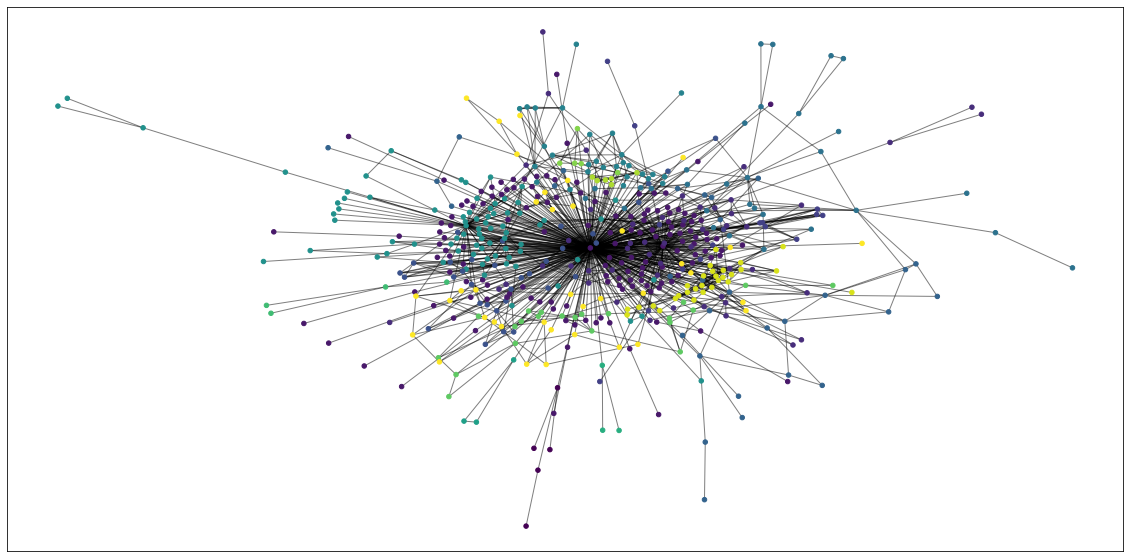

In [254]:
#An undirected graph of characters
G = gcc.to_undirected()

#computing the best partition
partition = community_louvain.best_partition(G)

all_partitions = list(partition.values())

plt.figure(figsize=(20,10))
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=20, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

* Explain the Louvain algorithm and how it finds communities in a newtork.

The Lauvain algorithm includes Modularity optimization and community aggregation executed one afther another until macimum modularity is achived and there are no more changes. 

The modularity optimization stage finds communities by randomly ordering all nodes in the network and then one by one remove and insert each note in a different community until no significant increase in modularity is verifier. 

The second step, community aggregation, includes merging together all nodes in the same community. The links between the giant nodes formed are the sum of the ones previously connecting nodes from the same different communities. The giant nodes also include self loops whixh are sums of all links inside the given community.

* Explain how you chose to identify the communities: Which algorithm did you use? (if you did not use the Louvain method, explain how the method you have used works)

We decided to use the Louvian method and implemented it using the python module Community.

Comment your results:

* How many communities did you find in total?

In [255]:
#A list including all communities
allC = dict(Counter(all_partitions))
sorted_c = dict(sorted(allC.items()))

print("Number of communities: ", len(sorted_c.keys()))

Number of communities:  17



* Compute the value of modularity with the partition created by the algorithm.

In [256]:
#The modularity
modularity = community_louvain.modularity(partition, G)

print("The modularity of the community partitioning: ", modularity)

The modularity of the community partitioning:  0.5649608222576259


* Plot the distribution of community sizes.

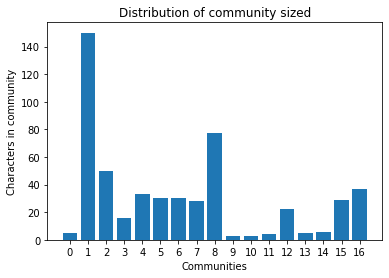

In [257]:
labels, values = zip(*sorted_c.items())

indexes = np.arange(len(labels))

plt.bar(indexes, values)
plt.xticks(indexes, labels)
plt.ylabel("Characters in community")
plt.xlabel("Communities")
plt.title('Distribution of community sized')
plt.show()

* For the 5 largest communities, create TF-IDF based rankings of words in each community.

In [258]:
#Find most common communities
mostCommonC = Counter(allC).most_common(5)
fiveLargest = []

for i in mostCommonC:
    fiveLargest.append(i[0])

print("The five most common communities: ", fiveLargest)

The five most common communities:  [1, 8, 2, 16, 4]


* There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.

The formuna for TF-IDF is as follows:

TF-IDF = TF * IDF where,

TF = Term count / Length of document and,

IDF = log(Length of corpus / Number of documents containing term)

    We calculated the TF-IDF by:
    - Finding the count of every single word within a race (Our Term count)
    - And dividing it by the length of our Race document (Our TF)
    - Finding for each word within the race in how many character document it appears (Num of docs containing terms)
    - Calculate the IDF 
    - Multiply the TF and IDF (Our TF-IDF)



* List the 5 top words for each community according to TF & TF-IDF.

In [317]:
#Function to find top five words  according to TF and TF-IDF

def calcTopFive(community, namesInCommunity):
    wordsInCommunity = defaultdict(list)
    appearsInCorpus = defaultdict(list)

    wordsByTF = defaultdict(list)
    wordsByTFIDF = defaultdict(list)
    documentLength = 0

    for name in namesInCommunity:
        if name in listOfCleanCheckNames :

            theText = nltk.Text(newcorpus.words(name + '.txt'))
            fdist = FreqDist(theText)
            documentLength += len(theText)
            
            for word in fdist:
                wordTF = fdist[word]
                    
                wordsInCommunity[word].append(wordTF)
                appearsInCorpus[word].append(name)

    
    for key, value in wordsInCommunity.items():
        TF = sum(value) / documentLength
        IDF = math.log(len(namesInCommunity) / len(appearsInCorpus[key]))
        TFIDF = math.ceil(TF*IDF)

        wordsByTF[key].append(TF)
        wordsByTFIDF[key].append(TFIDF)
 
    topFiveTF = Counter(wordsByTF).most_common(5)
    topFiveTFIDF = Counter(wordsByTFIDF).most_common(5)

    print("The top five words in community number:", community)
    
    TfList = []
    for i in topFiveTF:
        TfList.append(i[0])

    print("by using TF:\t", TfList)
        
    TfidfList = []
    for i in topFiveTFIDF:
        TfidfList.append(i[0])
        
    print("by using TF-IDF:", TfidfList)
    print("-------------------------------------------------------------")
    print("\n")

In [318]:
communities = defaultdict(list)

#All characters in each community
for key, value in partition.items(): 
    key = key.replace(" ", "_")
    communities[value].append(key)
    
sortedC = sorted(communities)

#Run calcTopFive function for all communities
for key, value in sortedC.items():
    calcTopFive(key, value)
    


The top five words in community number: 0
by using TF:	 ['horse', 'stable', 'also', 'white', 'breath']
by using TF-IDF: ['horse', 'stable', 'also', 'white', 'one']
-------------------------------------------------------------


The top five words in community number: 8
by using TF:	 ['gerudo', 'town', 'tell', 'say', 'speaks']
by using TF-IDF: ['stable', 'horse', 'serenne', 'snowfield', 'breath']
-------------------------------------------------------------


The top five words in community number: 2
by using TF:	 ['princess', 'hyrule', 'wa', 'time', 'sheikah']
by using TF-IDF: ['stable', 'tell', 'tabantha', 'bridge', 'storm']
-------------------------------------------------------------


The top five words in community number: 6
by using TF:	 ['guardian', 'ganon', 'goron', 'vah', 'beast']
by using TF-IDF: ['brother', 'goron', 'training', 'shrine', 'blood']
-------------------------------------------------------------


The top five words in community number: 4
by using TF:	 ['blue', '

*  Are these words more descriptive of the community than just the TF? Justify your answer.

At first glance, When comparing the TF and TF-IDF words, it seems that the words are similar in both methods. However if a closer look is taken it can be argued that the words in TF-IDF are more descriptive for the entire community. An example of this is community number two: 

by using TF:	 ['princess', 'hyrule', 'wa', 'time', 'sheikah']

by using TF-IDF: ['stable', 'tell', 'tabantha', 'bridge', 'storm']

This is due to the fact that in TF-IDF words that appear in more documents than others have more weight. This assures that words that appear frequently but only in one document (a single character in our case) do not have the same weight as words that appear frequiently all arount the community.

## Part 4: Sentiment of communities


* Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities.


* A couple of additional instructions you will need below:


* We name each community by its three most connected characters.

* Average the average sentiment of the nodes in each community to find a community level sentiment.



Here's what you need to do (repeat these steps and report your results for both LabMT and VADER):


* Calculate and store sentiment for every character

Let's start with LabMT.


In [49]:
CharactersDialogue = {}

# Opening JSON file
with open('CharactersDialogue.json') as json_file:
    data = json.load(json_file)
    CharactersDialogue = data

We create a functin preppData which prepares the data for the sentiment calculations. It tokenizes, lemmatizes and sets all the worst to lower case.

In [57]:
lemmatizer = WordNetLemmatizer()

def preppData(CharacterText):
    preppedText = []

    for sentance in CharacterText:
        #tokenize and to lowercase
        tokenizedSentance = nltk.word_tokenize(sentance.lower())
        for token in tokenizedSentance:
            #lemmatize words
            preppedText.append(lemmatizer.lemmatize(token))

    return preppedText

We also create a function sentimentScore which calculates the sentiment scors for all charecters in a communicy and then returns an average sentiment for a character.

In [59]:
data = pd.read_csv('Data_Set_S1.txt', sep="\t", header=None)
data.columns = ["word", "happiness_rank", "happiness_average", "happiness_standard_deviation", "twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]
sentimentData = data[["word", "happiness_average"]]

def sentimentScore(preppedCharData):
    scores = []

    for token in preppedCharData:
        wordRow = sentimentData[sentimentData.isin([token]).any(axis=1)]

        if not wordRow.empty:
            scores.append(wordRow.iloc[0]["happiness_average"])

    scoreLen = len(scores)
    scoreSum = sum(scores)
    scoreAvg = scoreSum /scoreLen

    return scoreAvg

In [68]:
#calculate the average sentiment of every character

charSentScores = {}

for key, value in CharactersDialogue.items():
    #prepare data
    preppedCharData = preppData(CharactersDialogue[key])
    #calculate scores
    sentScore = sentimentScore(preppedCharData)
    charSentScores[key] = sentScore

print("All character scores have been successfully calculated!")

All character scores have been successfully calculated!


We now calculate the sentiment scores by using Vader

In [69]:
analyzer = SentimentIntensityAnalyzer()
scores = []

#A function for calculating  Vader sentiment scores
def vaderSentimentScores(preppedCharData):
    for sentence in preppedCharData:

        vs = analyzer.polarity_scores(sentence)
        scores.append(vs['compound'])

    scoreLen = len(scores)
    scoreSum = sum(scores)
    scoreAvg = scoreSum /scoreLen

    return scoreAvg

vaderSentScores = {}

for key, value in CharactersDialogue.items():
    sentScore = vaderSentimentScores(value)
    vaderSentScores[key] = sentScore

print("All Vader sentiment scores have been successfully calculated!")

All Vader sentiment scores have been successfully calculated!


* Create a histogram of all character's associated sentiments.

(array([ 4.,  2.,  3., 12., 11., 24., 70., 53., 66., 79., 55., 65., 12.,
         6.,  7.,  2.,  1.,  0.,  2.,  1.]),
 array([5.165     , 5.20505357, 5.24510714, 5.28516071, 5.32521429,
        5.36526786, 5.40532143, 5.445375  , 5.48542857, 5.52548214,
        5.56553571, 5.60558929, 5.64564286, 5.68569643, 5.72575   ,
        5.76580357, 5.80585714, 5.84591071, 5.88596429, 5.92601786,
        5.96607143]),
 <BarContainer object of 20 artists>)

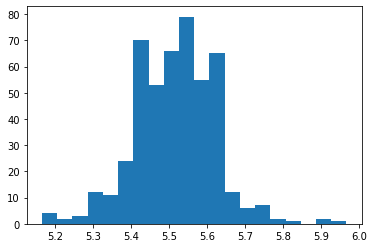

In [70]:
# Histogram using the LabMT sentiment scores

LabMTValues = []  

for key, value in charSentScores.items():
    LabMTValues.append(value)

plt.hist(LabMTValues, bins=20)

(array([ 54., 301.,  65.,  31.,  13.,   4.,   2.,   0.,   0.,   2.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([0.18083972, 0.18762531, 0.19441091, 0.2011965 , 0.2079821 ,
        0.21476769, 0.22155329, 0.22833888, 0.23512448, 0.24191007,
        0.24869567, 0.25548126, 0.26226686, 0.26905245, 0.27583804,
        0.28262364, 0.28940923, 0.29619483, 0.30298042, 0.30976602,
        0.31655161]),
 <BarContainer object of 20 artists>)

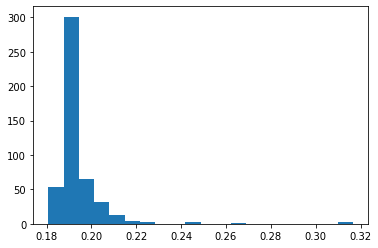

In [71]:
# Histogram using the Vader sentiment scores

vaderValues = []

for key, value in vaderSentScores.items():
    vaderValues.append(value)

plt.hist(vaderValues, bins=20)

* What are the 10 characters with happiest and saddest pages?


In [86]:
#LabMT
sortedScores = sorted(charSentScores.items(), key=lambda x: x[1])

print("10 happiest characters by using LabMT: ")
LSort = []

for i in sortedScores[0:10]:
    LSort.append(i[0])

print(LSort)

print("10 saddest characters by using LabMT: ")

LSortSad = []

for i in sortedScores[-10:]:
    LSortSad.append(i[0])

print(LSortSad)
print("-------------------------------------")

#Vader
sortedVaderScores = sorted(vaderSentScores.items(), key=lambda x: x[1])

print("10 happiest characters by using Vader: ")
VSort = []

for i in sortedVaderScores[0:10]:
    VSort.append(i[0])

print(VSort)

print("10 saddest characters by using Vader: ")
VSortSad = []

for i in sortedVaderScores[-10:]:
    VSortSad.append(i[0])

print(VSortSad)

10 happiest characters by using LabMT: 
['Aya', 'Kotta', 'Kenyo', 'Walton', 'Bargoh', 'Flaxel', 'Strade', 'Palme', 'Sudrey', 'Drak']
10 saddest characters by using LabMT: 
['Katta', 'Notts', 'Shamae', 'Pepp', 'Toren', 'Kula', 'Tasho', 'Narah', 'Zooki', 'Kinov']
-------------------------------------
10 happiest characters by using Vader: 
['Akrah', 'Tanko', 'Tray', 'Daag Chokah', 'Garshon', 'Onya', 'Ketoh Wawai', 'Volcon', 'Tasho', 'Kuhn Sidajj']
10 saddest characters by using Vader: 
['Cambo', 'Heehl', 'Ena', 'Daruk', 'Endai', 'Baumar', 'Beedle', 'Bayge', 'Baddek', 'Banji']


The next step is to compute the sentiment of communities:

In [89]:
#All communities by numeration
communities = defaultdict(list)

for key, value in partition.items(): 
    communities[value].append(key)


In [95]:
#Community sentiment scores using LabMT

LabMTCommunityScores = {}

for key, value in communities.items():
    #LabM
    charScoresLabmt = []

    for character in value:
        if character in CharactersDialogue:
            preppedCharData = preppData(CharactersDialogue[character])
            sentScore = sentimentScore(preppedCharData)
            charScoresLabmt.append(sentScore)
    LabmTscoreLen = len(charScoresLabmt)
    LabmTscoreSum = sum(charScoresLabmt)
    if LabmTscoreLen != 0:
        LabmTscoreAvg = LabmTscoreSum /LabmTscoreLen
        LabMTCommunityScores[key] = LabmTscoreAvg

print("The community centiment scores using LabMT have been successfuly computed!")
        

The community centiment scores using LabMT have been successfuly computed!


In [94]:
#Community sentiment scores using Vader

vaderCommunityScores = {}
charScoresVader = []
for key, value in communities.items():
    for character in value:
        if character in CharactersDialogue:
            charScoresVader.append(vaderSentimentScores(value))

    vaderScoreLen = len(charScoresVader)
    vaderScoreSum = sum(charScoresVader)
    vaderScoreAvg = vaderScoreSum /vaderScoreLen

    vaderCommunityScores[key] = vaderScoreAvg

print("The community centiment scores using Vader have been successfuly computed!")

The community centiment scores using Vader have been successfuly computed!


* What are the three happiest communities according to the LabMT wordlist approach? What about VADER?


In [109]:
#LabMT
sortedLabMTCommunityScores = sorted(LabMTCommunityScores.items(), key=lambda x: x[1])

print("3 happiest communities by using LabMT: ", sortedLabMTCommunityScores[0:3])

print("-------------------------------------")

#Vader
sortedVaderCommunityScores = sorted(vaderCommunityScores.items(), key=lambda x: x[1])

print("3 happiest communities by using Vader: ", sortedVaderCommunityScores[0:3])

3 happiest communities by using LabMT:  [(2, 5.316780185758519), (3, 5.425563415002206), (8, 5.427229553593743)]
-------------------------------------
3 happiest communities by using Vader:  [(15, 0.046120094369485505), (17, 0.046120094369485505), (9, 0.046238645181717136)]


* What are the three saddest communities according to the LabMT wordlist approach? What about VADER?

In [112]:
#LabMT

print("3 saddest communities by using LabMT: ", sortedLabMTCommunityScores[-3:])

print("-------------------------------------")

#Vader

print("3 saddest communities by using Vader: ", sortedVaderCommunityScores[-3:])

3 saddest communities by using LabMT:  [(12, 5.54842233883425), (10, 5.561504265663544), (9, 5.599151107568822)]
-------------------------------------
3 saddest communities by using Vader:  [(6, 0.057337408854838706), (1, 0.0581456528475343), (0, 0.06007584120434104)]


* Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods.


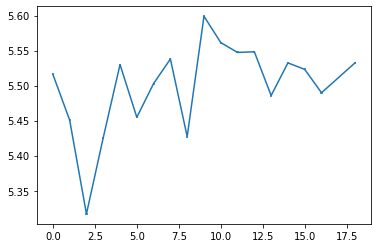

In [106]:
#Bar plot using LabMT

sortedLabMTCommunityScores = collections.OrderedDict(sorted(LabMTCommunityScores.items()))

commVader = []
x = []
for key, value in sortedLabMTCommunityScores.items():
    commVader.append(value)
    x.append(key)

vaderStddev = np.std(commVader)
plt.errorbar(x, commVader, xerr = vaderStddev)
plt.show()

OrderedDict([(0, 0.06007584120434104), (1, 0.0581456528475343), (2, 0.046409249466635584), (3, 0.056895344680375534), (4, 0.05602429166146546), (5, 0.04633545222055552), (6, 0.057337408854838706), (7, 0.050346476649820775), (8, 0.05004963636815764), (9, 0.046238645181717136), (10, 0.0496468328659253), (11, 0.049085669333170635), (12, 0.048536387686284856), (13, 0.048211833099609004), (14, 0.04725266183521072), (15, 0.046120094369485505), (16, 0.0471413181178674), (17, 0.046120094369485505), (18, 0.04643408165674993)])


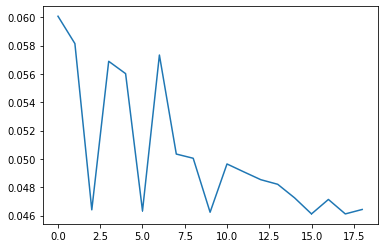

In [105]:
#Bar plot using Vader

sortedVaderScores = collections.OrderedDict(sorted(vaderCommunityScores.items()))
print(sortedVaderScores)


commVader = []
x = []
for key, value in sortedVaderScores.items():
    commVader.append(value)
    x.append(key)

vaderStddev = np.std(commVader)
plt.errorbar(x, commVader, xerr = vaderStddev)
plt.show()

* Explain the difference between the two methods and compare the results you have obtained above.

In The LabMT method a list of tokens is compared to the LabMT wordlist, a set of 10.222 words and their average happiness evaluations gathered in the Mechanical Turk study. The tokes are words which have been processed from strings to make sure they all have been lemmatized and are lowercase. In our case that means checking for every word in a characters word list if that word is included in the LabMT list. If that is the case then the happiness score of that word is documented. This way an average happiness score of each character can be collected. 

In the Vader method a score is computed similairly to the LabMT method described above but it also includes a set of rules in order to enhance and make the results more precise. For example if a token includes an exclemation mark or is in ALL CAPS the sentiment intensity is boosted and if there is a negation word like "not" before the word the sentiment score is lowered.

Comparing the two graphs above we can see that there are more distinct differences in the vader results than in the LabMt


* What is the advantage of using a rule-based method over the dictionary-based approach?

These comparisons suggest that the Vader method would have more precise results than LabMT, resulting in higher highs and lower lows. That can be confirmed when comparing the two charts above.
